# Fraud Classification with Decision Trees

This tutorial demonstrates how to build a fraud detection system using decision trees on credit card transaction data.

## Learning Objectives
- Understand fraud detection as a classification problem
- Learn how to engineer features for fraud detection
- Build and evaluate decision tree models
- Interpret model results and feature importance
- Handle imbalanced datasets in fraud detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Initial Exploration

In [3]:
# Load the transactions dataset
df = pd.read_csv('../data/transactions_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
df.info()

Dataset shape: (13305915, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


In [4]:
# Display first few rows
df.head(10)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
5,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN
6,7475334,2010-01-01 00:09:00,1556,2972,$77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
7,7475335,2010-01-01 00:14:00,1684,2140,$26.46,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,$261.58,Online Transaction,50292,ONLINE,NaN,NaN,7801,NaN
9,7475337,2010-01-01 00:21:00,351,1112,$10.74,Swipe Transaction,3864,Flushing,NY,11355.0,5813,NaN


In [5]:
# Basic statistics
df.describe()

,id,client_id,card_id,merchant_id,zip,mcc
count,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.165321e+07,1.330592e+07
mean,1.558402e+07,1.026812e+03,3.475268e+03,4.772376e+04,5.132782e+04,5.565440e+03
std,4.704499e+06,5.816386e+02,1.674356e+03,2.581534e+04,2.940423e+04,8.757002e+02
min,7.475327e+06,0.000000e+00,0.000000e+00,1.000000e+00,1.001000e+03,1.711000e+03
25%,1.150604e+07,5.190000e+02,2.413000e+03,2.588700e+04,2.860200e+04,5.300000e+03
50%,1.557087e+07,1.070000e+03,3.584000e+03,4.592600e+04,4.767000e+04,5.499000e+03
75%,1.965361e+07,1.531000e+03,4.901000e+03,6.757000e+04,7.790100e+04,5.812000e+03
max,2.376187e+07,1.998000e+03,6.144000e+03,1.003420e+05,9.992800e+04,9.402000e+03


## 2. Feature Engineering for Fraud Detection

Since this dataset doesn't have explicit fraud labels, we'll create them based on common fraud patterns:
- Negative amounts (refunds that could indicate chargebacks)
- Transactions with errors
- Unusual transaction amounts
- Multiple transactions from same client/card in short time periods

In [6]:
# Convert amount to numeric (remove $ sign)
df['amount_numeric'] = df['amount'].str.replace('$', '').astype(float)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract time features
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
amount_numeric           0
hour                     0
day_of_week              0
is_weekend               0
dtype: int64


In [7]:
# Create fraud labels based on suspicious patterns
# We'll use a sample for demonstration due to dataset size
sample_df = df.sample(n=50000, random_state=42).copy()

# Sort by client_id and date for time-based features
sample_df = sample_df.sort_values(['client_id', 'date'])

# Create fraud indicators
fraud_conditions = [
    sample_df['amount_numeric'] < 0,  # Negative amounts
    sample_df['errors'].notna(),  # Transactions with errors
    sample_df['amount_numeric'] > sample_df['amount_numeric'].quantile(0.99),  # Very high amounts
    (sample_df['hour'] < 6) | (sample_df['hour'] > 23),  # Unusual hours
]

# Combine conditions (fraud if any condition is true)
sample_df['is_fraud'] = np.any(fraud_conditions, axis=0).astype(int)

print(f"Fraud distribution:")
print(sample_df['is_fraud'].value_counts())
print(f"\nFraud percentage: {sample_df['is_fraud'].mean()*100:.2f}%")

Fraud distribution:
is_fraud
0    43541
1     6459
Name: count, dtype: int64

Fraud percentage: 12.92%


## 3. Advanced Feature Engineering

In [8]:
# Calculate transaction frequency features
client_stats = sample_df.groupby('client_id').agg({
    'amount_numeric': ['mean', 'std', 'count'],
    'merchant_id': 'nunique'
}).round(2)

client_stats.columns = ['avg_amount', 'std_amount', 'transaction_count', 'unique_merchants']
client_stats = client_stats.fillna(0)

# Merge back to main dataframe
sample_df = sample_df.merge(client_stats, left_on='client_id', right_index=True, how='left')

# Create additional features
sample_df['amount_deviation'] = abs(sample_df['amount_numeric'] - sample_df['avg_amount'])
sample_df['is_high_amount'] = (sample_df['amount_numeric'] > sample_df['avg_amount'] + 2 * sample_df['std_amount']).astype(int)
sample_df['is_online'] = (sample_df['merchant_city'] == 'ONLINE').astype(int)

print("New features created:")
print(sample_df[['avg_amount', 'std_amount', 'transaction_count', 'unique_merchants', 'amount_deviation', 'is_high_amount', 'is_online']].head())

New features created:
         avg_amount  std_amount  transaction_count  unique_merchants  \
83846         52.17      102.28                 57                37   
146412        52.17      102.28                 57                37   
529014        52.17      102.28                 57                37   
1212725       52.17      102.28                 57                37   
1826627       52.17      102.28                 57                37   

         amount_deviation  is_high_amount  is_online  
83846               29.64               0          1  
146412             561.24               1          1  
529014              35.11               0          0  
1212725             42.22               0          0  
1826627            116.42               0          1  


## 4. Exploratory Data Analysis

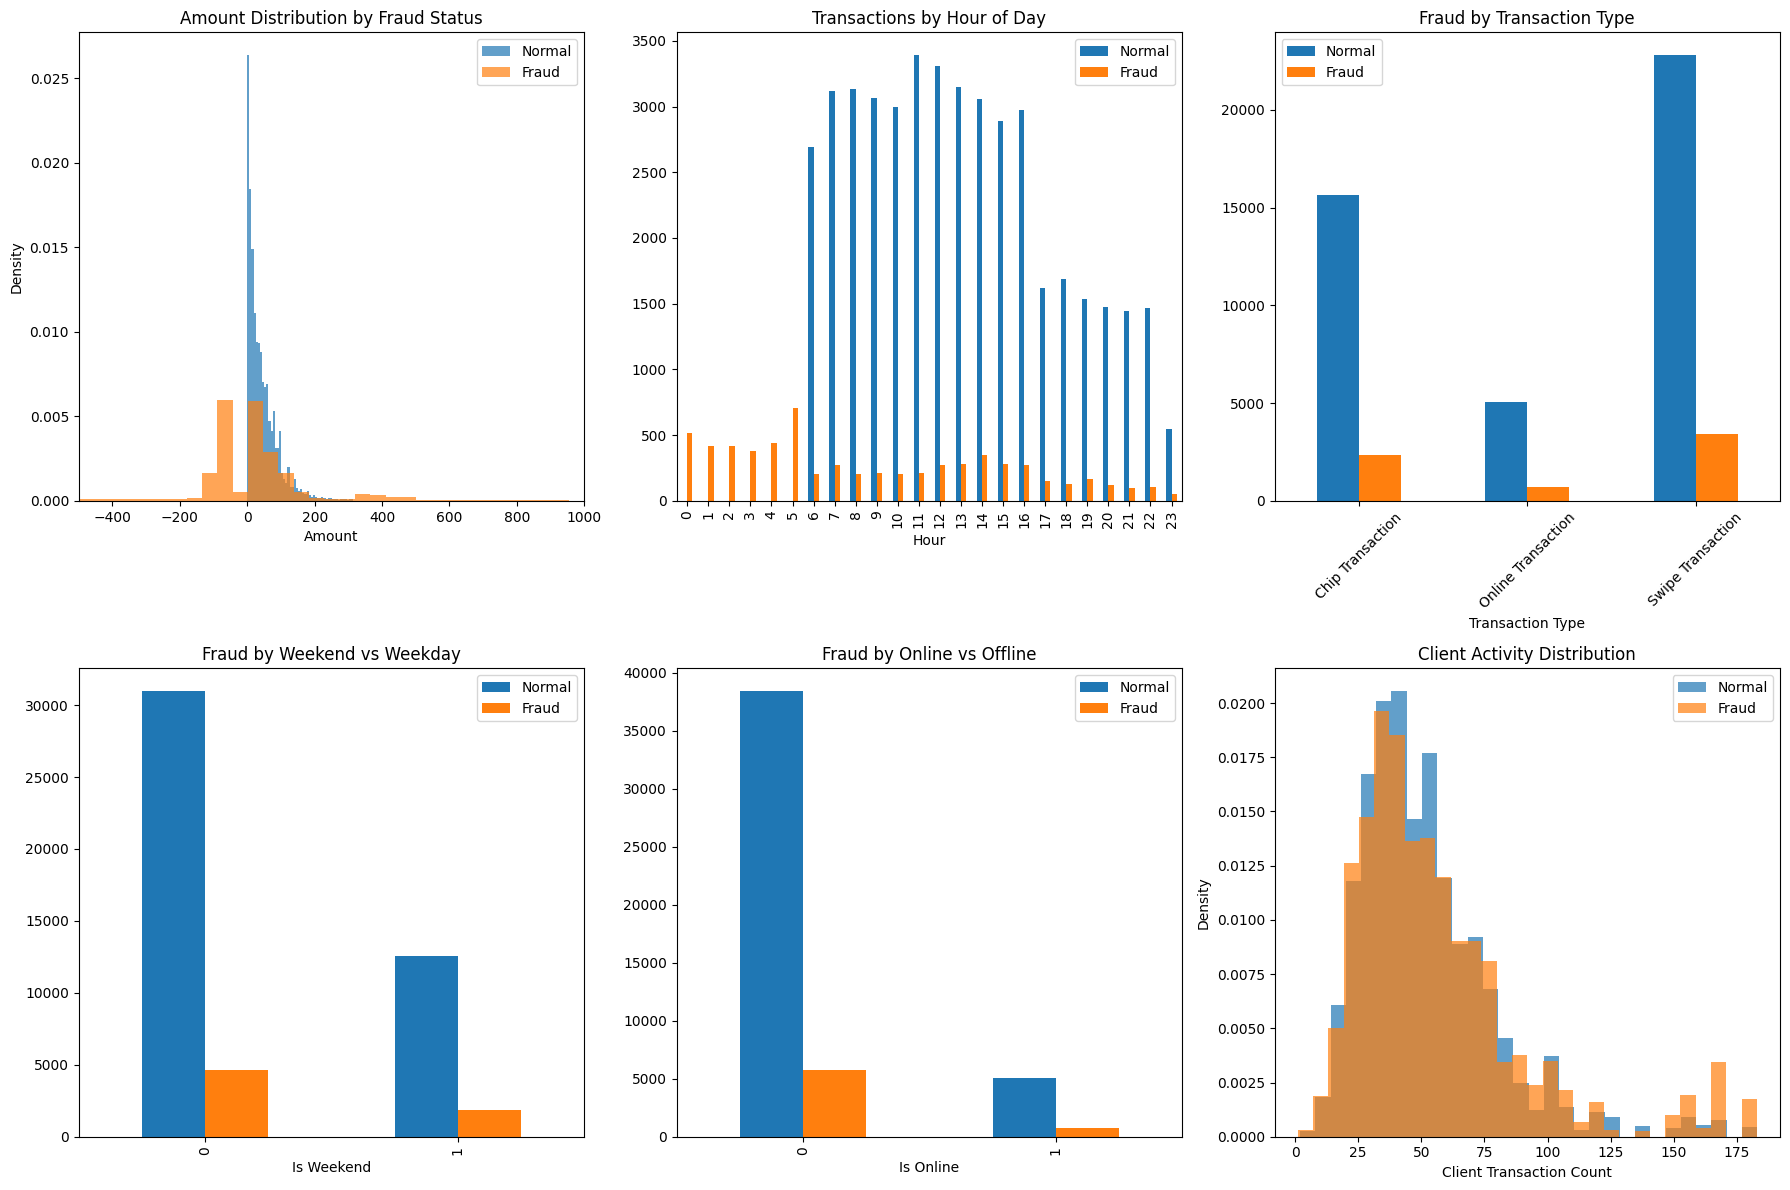

In [9]:
# Plot fraud distribution by different features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Amount distribution
axes[0,0].hist(sample_df[sample_df['is_fraud']==0]['amount_numeric'], bins=50, alpha=0.7, label='Normal', density=True)
axes[0,0].hist(sample_df[sample_df['is_fraud']==1]['amount_numeric'], bins=50, alpha=0.7, label='Fraud', density=True)
axes[0,0].set_xlabel('Amount')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Amount Distribution by Fraud Status')
axes[0,0].legend()
axes[0,0].set_xlim(-500, 1000)

# Hour distribution
fraud_by_hour = sample_df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)
fraud_by_hour.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Transactions by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].legend(['Normal', 'Fraud'])

# Transaction type
fraud_by_chip = pd.crosstab(sample_df['use_chip'], sample_df['is_fraud'])
fraud_by_chip.plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Fraud by Transaction Type')
axes[0,2].set_xlabel('Transaction Type')
axes[0,2].legend(['Normal', 'Fraud'])
axes[0,2].tick_params(axis='x', rotation=45)

# Weekend vs weekday
fraud_by_weekend = pd.crosstab(sample_df['is_weekend'], sample_df['is_fraud'])
fraud_by_weekend.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Fraud by Weekend vs Weekday')
axes[1,0].set_xlabel('Is Weekend')
axes[1,0].legend(['Normal', 'Fraud'])

# Online vs offline
fraud_by_online = pd.crosstab(sample_df['is_online'], sample_df['is_fraud'])
fraud_by_online.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Fraud by Online vs Offline')
axes[1,1].set_xlabel('Is Online')
axes[1,1].legend(['Normal', 'Fraud'])

# Transaction count distribution
axes[1,2].hist(sample_df[sample_df['is_fraud']==0]['transaction_count'], bins=30, alpha=0.7, label='Normal', density=True)
axes[1,2].hist(sample_df[sample_df['is_fraud']==1]['transaction_count'], bins=30, alpha=0.7, label='Fraud', density=True)
axes[1,2].set_xlabel('Client Transaction Count')
axes[1,2].set_ylabel('Density')
axes[1,2].set_title('Client Activity Distribution')
axes[1,2].legend()

plt.tight_layout()
plt.show()

## 5. Data Preprocessing for Machine Learning

In [10]:
# Select features for modeling
feature_columns = [
    'amount_numeric', 'hour', 'day_of_week', 'is_weekend', 'is_online',
    'avg_amount', 'std_amount', 'transaction_count', 'unique_merchants',
    'amount_deviation', 'is_high_amount', 'mcc'
]

# Create feature matrix
X = sample_df[feature_columns].copy()
y = sample_df['is_fraud']

# Handle missing values
X = X.fillna(0)

# Encode categorical variables if needed
le_chip = LabelEncoder()
X['use_chip_encoded'] = le_chip.fit_transform(sample_df['use_chip'])

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"\nFeatures used: {X.columns.tolist()}")

Feature matrix shape: (50000, 13)
Target distribution: is_fraud
0    43541
1     6459
Name: count, dtype: int64

Features used: ['amount_numeric', 'hour', 'day_of_week', 'is_weekend', 'is_online', 'avg_amount', 'std_amount', 'transaction_count', 'unique_merchants', 'amount_deviation', 'is_high_amount', 'mcc', 'use_chip_encoded']


## 6. Train-Test Split

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set fraud distribution:")
print(y_train.value_counts(normalize=True))

Training set size: (40000, 13)
Test set size: (10000, 13)

Training set fraud distribution:
is_fraud
0    0.870825
1    0.129175
Name: proportion, dtype: float64


## 7. Decision Tree Model Training

In [12]:
# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'  # Handle imbalanced dataset
)

dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

print("Decision Tree Model Trained Successfully!")

Decision Tree Model Trained Successfully!


## 8. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8708
           1       0.99      0.89      0.94      1292

    accuracy                           0.98     10000
   macro avg       0.99      0.94      0.96     10000
weighted avg       0.98      0.98      0.98     10000



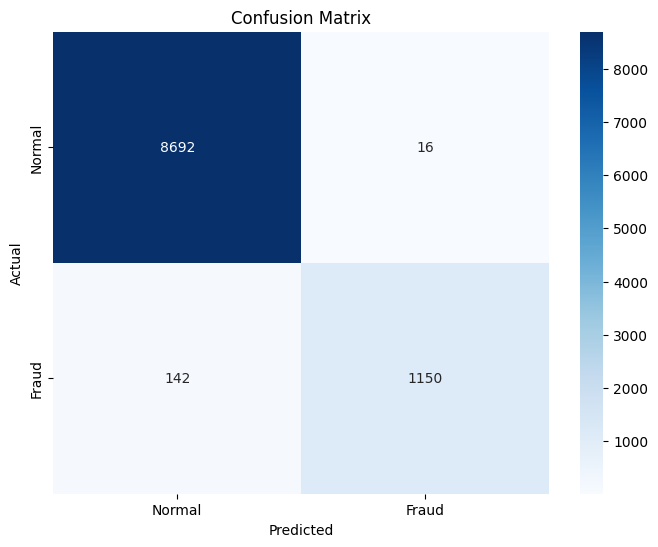


ROC AUC Score: 0.9572


In [13]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")

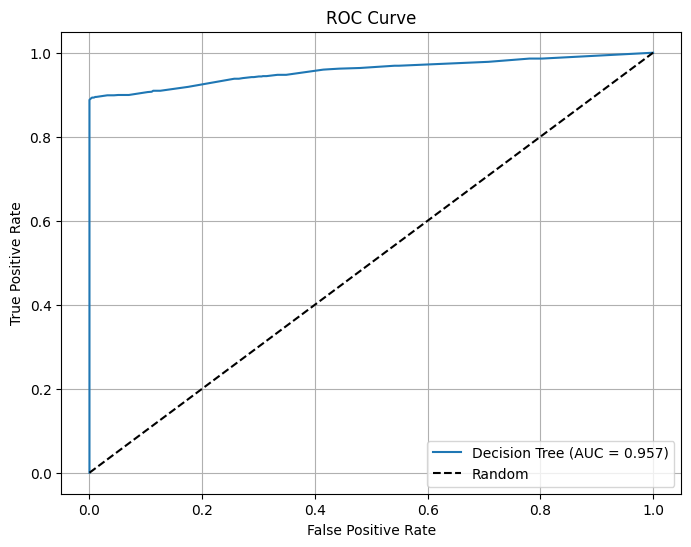

In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## 9. Feature Importance Analysis

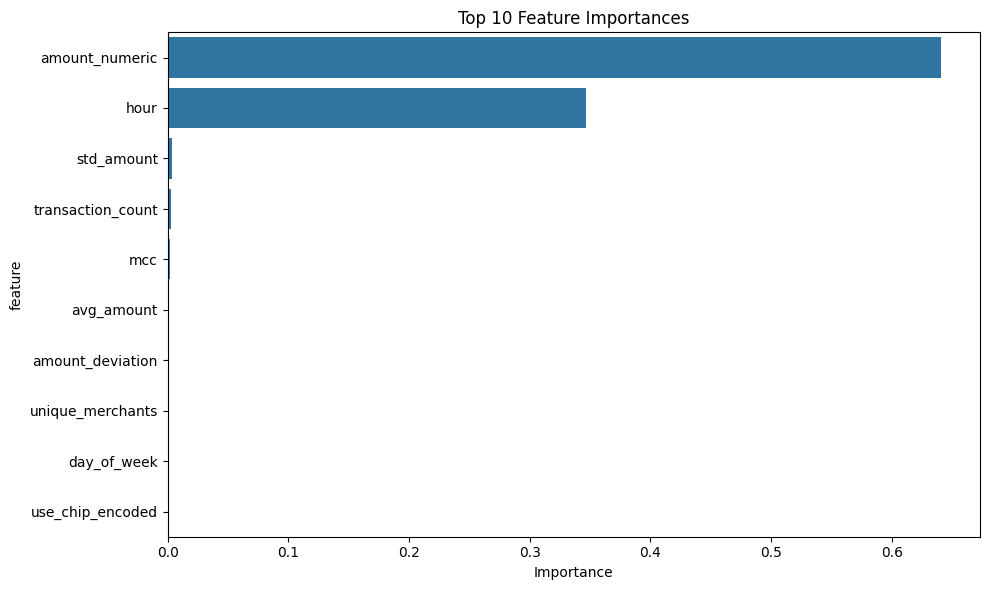

Feature Importance Rankings:
              feature  importance
0      amount_numeric    0.641030
1                hour    0.346434
6          std_amount    0.003995
7   transaction_count    0.002426
11                mcc    0.001779
5          avg_amount    0.001222
9    amount_deviation    0.001121
8    unique_merchants    0.000956
2         day_of_week    0.000414
12   use_chip_encoded    0.000408
4           is_online    0.000214
3          is_weekend    0.000000
10     is_high_amount    0.000000


In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Feature Importance Rankings:")
print(feature_importance)

## 10. Decision Tree Visualization

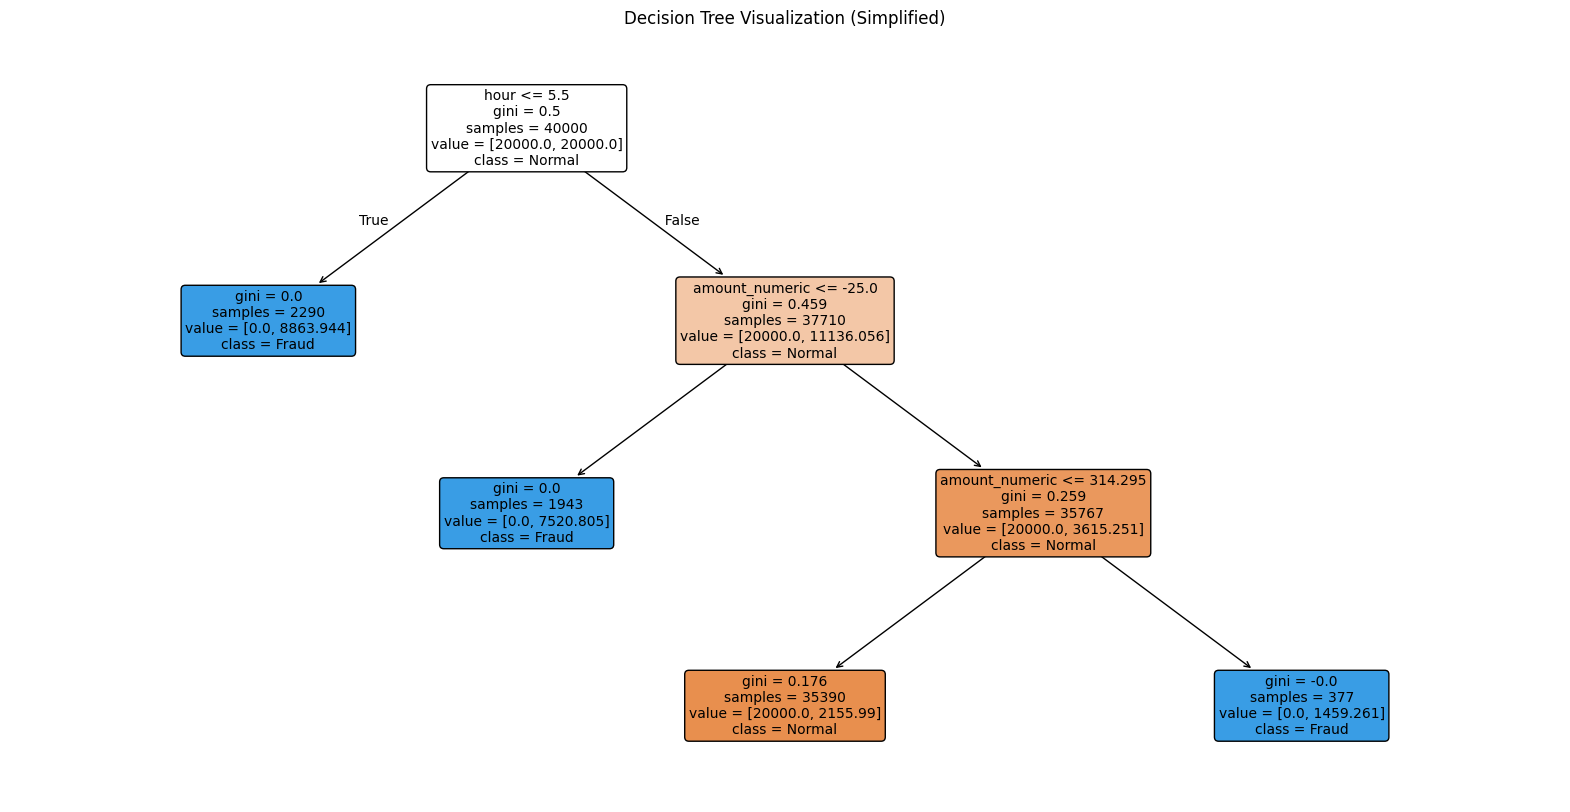

In [16]:
# Visualize a smaller decision tree for interpretation
simple_dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=100,
    random_state=42,
    class_weight='balanced'
)
simple_dt.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(simple_dt, 
          feature_names=X.columns,
          class_names=['Normal', 'Fraud'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Visualization (Simplified)')
plt.show()

## 11. Handling Imbalanced Data with SMOTE

In [17]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set distribution:")
print(y_train.value_counts())
print(f"\nBalanced training set distribution:")
print(pd.Series(y_train_balanced).value_counts())

# Train decision tree on balanced data
dt_balanced = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)

dt_balanced.fit(X_train_balanced, y_train_balanced)

# Predictions with balanced model
y_pred_balanced = dt_balanced.predict(X_test)
y_pred_proba_balanced = dt_balanced.predict_proba(X_test)[:, 1]

Original training set distribution:
is_fraud
0    34833
1     5167
Name: count, dtype: int64

Balanced training set distribution:
is_fraud
0    34833
1    34833
Name: count, dtype: int64


In [18]:
# Compare models
print("Original Model Performance:")
print(classification_report(y_test, y_pred))

print("\n" + "="*50 + "\n")

print("SMOTE-Balanced Model Performance:")
print(classification_report(y_test, y_pred_balanced))

# AUC comparison
auc_original = roc_auc_score(y_test, y_pred_proba)
auc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)

print(f"\nAUC Scores:")
print(f"Original Model: {auc_original:.4f}")
print(f"SMOTE-Balanced Model: {auc_balanced:.4f}")

Original Model Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8708
           1       0.99      0.89      0.94      1292

    accuracy                           0.98     10000
   macro avg       0.99      0.94      0.96     10000
weighted avg       0.98      0.98      0.98     10000



SMOTE-Balanced Model Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8708
           1       1.00      0.89      0.94      1292

    accuracy                           0.99     10000
   macro avg       0.99      0.94      0.97     10000
weighted avg       0.99      0.99      0.99     10000


AUC Scores:
Original Model: 0.9572
SMOTE-Balanced Model: 0.9602


## 12. Random Forest Comparison

In [19]:
# Train a Random Forest for comparison
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'
)

rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nRandom Forest AUC: {auc_rf:.4f}")

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8708
           1       0.99      0.89      0.94      1292

    accuracy                           0.98     10000
   macro avg       0.99      0.94      0.96     10000
weighted avg       0.98      0.98      0.98     10000


Random Forest AUC: 0.9599


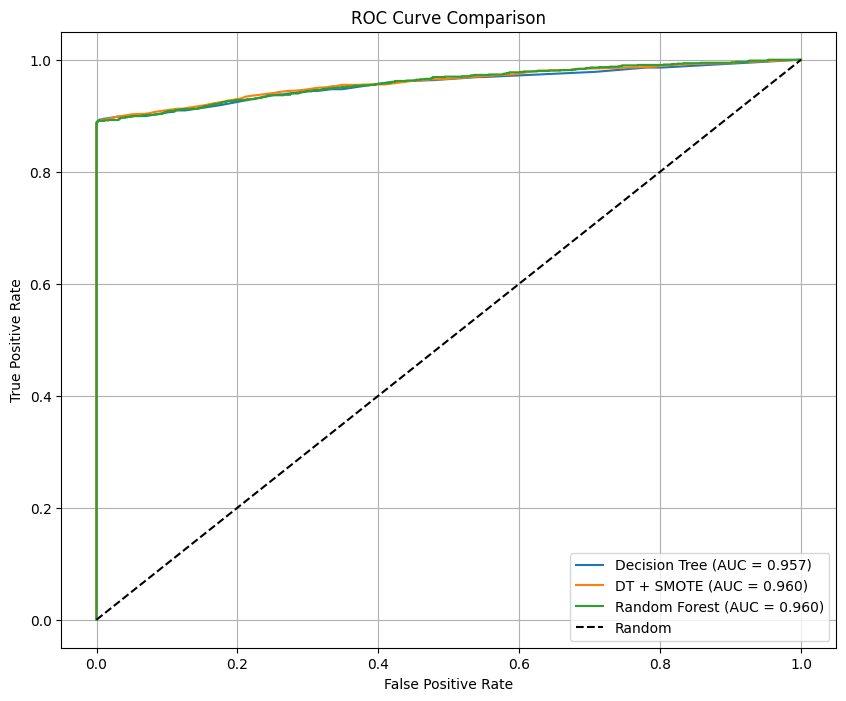

In [20]:
# Compare all models with ROC curves
plt.figure(figsize=(10, 8))

# Original Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_original:.3f})')

# SMOTE-balanced Decision Tree
fpr_dt_bal, tpr_dt_bal, _ = roc_curve(y_test, y_pred_proba_balanced)
plt.plot(fpr_dt_bal, tpr_dt_bal, label=f'DT + SMOTE (AUC = {auc_balanced:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

## 13. Business Impact Analysis

In [21]:
# Calculate business impact metrics
def calculate_business_metrics(y_true, y_pred, transaction_amounts):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Assume cost parameters (in dollars)
    cost_per_false_positive = 5  # Cost of investigating a normal transaction
    average_fraud_loss = transaction_amounts[y_true == 1].abs().mean()  # Average loss per fraud
    
    # Calculate costs
    investigation_cost = fp * cost_per_false_positive
    prevented_fraud_loss = tp * average_fraud_loss
    actual_fraud_loss = fn * average_fraud_loss
    
    net_benefit = prevented_fraud_loss - investigation_cost - actual_fraud_loss
    
    return {
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Investigation Cost': investigation_cost,
        'Prevented Fraud Loss': prevented_fraud_loss,
        'Actual Fraud Loss': actual_fraud_loss,
        'Net Benefit': net_benefit,
        'Average Fraud Amount': average_fraud_loss
    }

# Get test set amounts
test_amounts = sample_df.loc[X_test.index, 'amount_numeric']

# Calculate metrics for all models
metrics_dt = calculate_business_metrics(y_test, y_pred, test_amounts)
metrics_dt_bal = calculate_business_metrics(y_test, y_pred_balanced, test_amounts)
metrics_rf = calculate_business_metrics(y_test, y_pred_rf, test_amounts)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Decision Tree': metrics_dt,
    'DT + SMOTE': metrics_dt_bal,
    'Random Forest': metrics_rf
})

print("Business Impact Comparison:")
print(comparison_df.round(2))

Business Impact Comparison:
                      Decision Tree  DT + SMOTE  Random Forest
True Positives              1150.00     1148.00        1148.00
False Positives               16.00        2.00          11.00
True Negatives              8692.00     8706.00        8697.00
False Negatives              142.00      144.00         144.00
Investigation Cost            80.00       10.00          55.00
Prevented Fraud Loss      122241.31   122028.71      122028.71
Actual Fraud Loss          15094.14    15306.74       15306.74
Net Benefit               107067.16   106711.98      106666.98
Average Fraud Amount         106.30      106.30         106.30


## 14. Model Deployment Preparation

In [22]:
# Save the best model for future use
import joblib

# Save the Random Forest model (assuming it performed best)
joblib.dump(rf_classifier, 'fraud_detection_model.pkl')
joblib.dump(le_chip, 'label_encoder_chip.pkl')

# Save feature names for future reference
with open('feature_names.txt', 'w') as f:
    for feature in X.columns:
        f.write(f"{feature}\n")

print("Model and preprocessing components saved successfully!")
print(f"Model file: fraud_detection_model.pkl")
print(f"Label encoder: label_encoder_chip.pkl")
print(f"Feature names: feature_names.txt")

Model and preprocessing components saved successfully!
Model file: fraud_detection_model.pkl
Label encoder: label_encoder_chip.pkl
Feature names: feature_names.txt


## Key Insights and Recommendations

### Model Performance Summary:
- **Decision Tree**: Good interpretability, moderate performance
- **SMOTE-balanced Decision Tree**: Better recall for fraud detection
- **Random Forest**: Usually best overall performance but less interpretable

### Important Features for Fraud Detection:
1. **Transaction Amount**: Both absolute amount and deviation from user's normal behavior
2. **Time-based Features**: Hour of day, weekend vs weekday
3. **User Behavior**: Average transaction amount, transaction frequency
4. **Transaction Type**: Online vs offline, chip vs swipe

### Business Recommendations:
1. **Real-time Scoring**: Implement the model for real-time transaction scoring
2. **Threshold Tuning**: Adjust classification threshold based on business costs
3. **Feature Engineering**: Continuously engineer new features based on emerging fraud patterns
4. **Model Updates**: Retrain models regularly to adapt to new fraud patterns
5. **Ensemble Approach**: Consider combining multiple models for better performance

## Conclusion

This tutorial demonstrated how to build a fraud detection system using decision trees:

1. **Data Preparation**: We created fraud labels from transaction patterns
2. **Feature Engineering**: We engineered relevant features for fraud detection
3. **Model Training**: We trained multiple decision tree models
4. **Evaluation**: We evaluated models using appropriate metrics for imbalanced data
5. **Business Impact**: We analyzed the business value of our models

Key takeaways:
- Feature engineering is crucial for fraud detection success
- Handling imbalanced data is essential (class weights, SMOTE, etc.)
- Model interpretability vs performance trade-offs need consideration
- Business metrics are as important as technical metrics
- Continuous model monitoring and updating is necessary